In [2]:
import os
from netCDF4 import Dataset as NetCDFFile
import time
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
from scipy.interpolate import griddata
#from pyresample import geometry,image, kd_tree
import copy
import isamcalc_lib as isam
import C14utils

In [2]:
# Here read in the results and calculate the D14C for each layer
fsample = 'Global_1DSBGC_NOCLIM.bgc-yearly-d14c-4d_2000s.nc'
nclu_obs=NetCDFFile(fsample,'r')
d14c = nclu_obs.variables['soc_del_c14'][:]
nclu_obs.close()

# SOC profile
fsoc = 'Global_1DSBGC_NOCLIM.bgc-yearly-3d_2000s.nc'
nclu_obs=NetCDFFile(fsoc,'r')
soc = nclu_obs.variables['soil_c_lev'][:]
nclu_obs.close()

# LC data
flc = 'verify_time_invarient.nc'
nclu_obs=NetCDFFile(flc,'r')
lc = nclu_obs.variables['c_pft_fraction'][:]
nclu_obs.close()
path='Global_1DSBGC.bgc-yearly-3d_2000s.nc'
nclu=NetCDFFile(path,'r')
fo2_2000 = nclu.variables['fo2'][:]
fna_2000 = nclu.variables['fna'][:]
latnc = nclu.variables['lat'][:]
lonnc = nclu.variables['lon'][:]
nclu.close()

# Need to get the mask to prevent running for useless grids.
fdv = 'dave_mask.nc'
nclu_obs=NetCDFFile(fdv,'r')
dv_msk = nclu_obs.variables['Davemask'][:]
nclu_obs.close()

# D14C is not possible to use PFT as weight.
# Need to get the 14C/12C ratio then use PFT as a weight.
rc14c12 = d14c/1000. + 1


rc14c12_all = -1000*np.ones((10, 360, 720))
for i in np.arange(0,10):
    rc14c12_all[i,:,:] = np.sum((rc14c12[i,:,:,:] * lc), axis=0)

d14c_all = 1000.*(rc14c12_all - 1)
    
d14c_all[d14c_all==0] = np.float('nan')
# Get a mask to filter out grids with no values
msk = d14c_all[0,:,:]
msk[dv_msk>0] = -1000
    
tau_topsoil = np.zeros((360, 720))
tau_subsoil = np.zeros((360, 720))
bulk_d14c_topsoil = -1000*np.ones((360, 720))
bulk_d14c_subsoil = -1000*np.ones((360, 720))

for i in np.arange(0,720):
    for j in np.arange(0,360):
        if(soc[0,j,i]>0):
            bulk_d14c_topsoil[j,i] = isam.avg_wt_topsoil(soc[:,j,i], d14c_all[:,j,i])
            bulk_d14c_subsoil[j,i] = isam.avg_wt_subsoil(soc[:,j,i], d14c_all[:,j,i])

print('Done the averaging!')

# Calculate the tau, one time for a lat
# Lat starts from 360 to 220 (20N ~ 80N), Dave Mcguire's regional mask is applied
# First transfer into a 1-D array then pass into cal_tau?
for i in np.arange(359,219,-1):
    print(i)
    # Weighted C14 for topsoil and subsoil separatedly
    # Preindustrial year - 1860
    # Contemporary year - 2000
    msk_inuse = msk[i,:]
    sampleyr = 2005*np.ones((720))
    sampleyr[msk_inuse<-400] = np.float('nan')
    # Calculate the turnover time
    tau, cost = C14utils.cal_tau(bulk_d14c_topsoil[i,:], sampleyr, 1, 0)
    tau_topsoil[i,:] = tau[:,0]
    tau, cost = C14utils.cal_tau(bulk_d14c_subsoil[i,:], sampleyr, 1, 0)
    tau_subsoil[i,:] = tau[:,0]

tau_topsoil[tau_topsoil>3000] = np.float('nan')
tau_subsoil[tau_subsoil>10000] = np.float('nan')

# Save the file as netcdf for display
# Create a NetCDF file to store the result
nc = NetCDFFile('tau_1d_2000s_NOCLIM.nc','w',format='NETCDF4_CLASSIC')
# Define a set of dimensions to be used in the file
#level = nc.createDimension('level', 10)
lat = nc.createDimension('lat', 360)
lon = nc.createDimension('lon', 720)
# Create variables
#levels = nc.createVariable('level', np.int32, ('level',))
latitudes = nc.createVariable('lat', np.float32, ('lat',))
longitudes = nc.createVariable('lon', np.float32, ('lon',))
# Create the actual 4-d variable
tau_top = nc.createVariable('tau_top', np.float32, ('lat','lon'))
tau_sub = nc.createVariable('tau_sub', np.float32, ('lat','lon'))

# Add Global Attributes
nc.description = 'Tau calculated from the Soil D14C.'
nc.history = 'Created ' + time.ctime(time.time())
nc.source = 'netCDF4 python module'

# Add Variable Attributes
latitudes.units = 'degree_north'
longitudes.units = 'degree_east'
tau_top.units = 'year'
tau_sub.units = 'year'

# Put longitude and latitude
lats = np.arange(-89.75,90.25,0.5)
lons = np.arange(0.25,360.25,0.5)
latitudes[:] = lats
longitudes[:] = lons
tau_top[:,:] = tau_topsoil
tau_sub[:,:] = tau_subsoil
nc.close()

isamcalc_lib.py:197: RuntimeWarning: invalid value encountered in double_scalars
  wt[i] =  weight[(i+5)] / weight_tot
isamcalc_lib.py:199: RuntimeWarning: invalid value encountered in double_scalars
  wt[i] = 0.3*weight[(i+5)] / weight_tot


Done the averaging!
359


C14utils.py:55: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cal_tau" failed type inference due to: Unknown attribute 'loadmat' of type Module(<module 'scipy.io' from 'C:\Users\sshu3\Anaconda2\lib\site-packages\scipy\io\__init__.pyc'>)

File "C14utils.py", line 69:
def cal_tau(d14c, smpyr, savecostn, tauonly):
    <source elided>
    tauslow = np.arange(2000, 200000, 5)
    atm14C = scipy.io.loadmat('atmD14C_50kBP-2012.mat')
    ^

[1] During: typing of get attribute at C14utils.py (69)

File "C14utils.py", line 69:
def cal_tau(d14c, smpyr, savecostn, tauonly):
    <source elided>
    tauslow = np.arange(2000, 200000, 5)
    atm14C = scipy.io.loadmat('atmD14C_50kBP-2012.mat')
    ^

  @autojit
C14utils.py:55: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "cal_tau" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "C14uti

358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less


340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220


In [6]:
# fsample = 'Global_1DSBGC.bgc-yearly-d14c-4d_1860s.nc'
fsample = 'Global_1DSBGC.bgc-yearly-d14c-4d_2000s.nc'
# fsample = 'Global_1DSBGC_NOCLIM.bgc-yearly-d14c-4d_2000s.nc'
# fsample = 'Global_1DSBGC_NOCO2.bgc-yearly-d14c-4d_2000s.nc'
nclu_obs=NetCDFFile(fsample,'r')
soc = nclu_obs.variables['soc_pools'][:]
soc14 = nclu_obs.variables['soc14_pools'][:]
input_flux = nclu_obs.variables['input_pools'][:]
resp_flux = nclu_obs.variables['resp_pools'][:]
nclu_obs.close()

# Need to get the mask to prevent running for useless grids.
fdv = 'dave_mask.nc'
nclu_obs=NetCDFFile(fdv,'r')
dv_msk = nclu_obs.variables['Davemask'][:]
nclu_obs.close()

# Another mask if choose to use NCSCD
path='ncscdv2_soilc_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
nclu_obs.close()
soc_ncscd = soc_ncscd_orig[0,:,:]
# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp

# First calculate the D14C of lab and res pools for each layer
soc[soc<=0] = np.float('nan')
soc14[soc14<=0] = np.float('nan')
d14c_lab = 1000.*(np.nansum(soc14[:,0:7,:,:], axis=1)/np.nansum(soc[:,0:7,:,:], axis=1) - 1)
d14c_res = 1000.*(soc14[:,7,:,:]/soc[:,7,:,:] - 1)

# Second, Calculate the D14C of lab and res pools regardless of the depth 
d14c_lab_tot = 1000.*(np.nansum(np.nansum(soc14[:,0:7,:,:], axis=1), axis=0)/np.nansum(np.nansum(soc[:,0:7,:,:], axis=1), axis=0) - 1)
d14c_res_tot = 1000.*(np.nansum(soc14[:,7,:,:], axis=0)/np.nansum(soc[:,7,:,:], axis=0) - 1)

# Third, get the D14C of lab and res pools for topsoil vs. subsoil
d14c_lab_top = 1000.*(np.nansum(np.nansum(soc14[0:5,0:7,:,:], axis=1), axis=0)/np.nansum(np.nansum(soc[0:5,0:7,:,:], axis=1), axis=0) - 1)
d14c_res_top = 1000.*(np.nansum(soc14[0:5,7,:,:], axis=0)/np.nansum(soc[0:5,7,:,:], axis=0) - 1)

d14c_lab_sub = 1000.*((np.nansum(np.nansum(soc14[5:7,0:7,:,:], axis=1), axis=0)+0.3*np.nansum(soc14[7,0:7,:,:], axis=0))\
                      /(np.nansum(np.nansum(soc[5:7,0:7,:,:], axis=1), axis=0)+0.3*np.nansum(soc[7,0:7,:,:], axis=0)) - 1)
d14c_res_sub = 1000.*((np.nansum(soc14[5:7,7,:,:], axis=0)+0.3*soc14[7,7,:,:])/(np.nansum(soc[5:7,7,:,:], axis=0)+0.3*soc[7,7,:,:]) - 1)


(360L, 720L)

In [9]:
# Calculate STT from D14C
tau_topsoil = np.zeros((360, 720))
tau_subsoil = np.zeros((360, 720))
msk = d14c_lab_top[:,:]
msk[dv_msk>0] = -1000

# Calculate the tau, one time for a lat
# Lat starts from 360 to 220 (20N ~ 80N), Dave Mcguire's regional mask is applied
# First transfer into a 1-D array then pass into cal_tau?
for i in np.arange(359,219,-1):
    print(i)
    # Weighted C14 for topsoil and subsoil separatedly
    # Preindustrial year - 1860
    # Contemporary year - 2000
    msk_inuse = msk[i,:]
    sampleyr = 2005*np.ones((720))
    sampleyr[msk_inuse<-400] = np.float('nan')
    # Calculate the turnover time
    tau, cost = C14utils.cal_tau(d14c_lab_sub[i,:], sampleyr, 1, 0)
    tau_topsoil[i,:] = tau[:,0]
    tau, cost = C14utils.cal_tau(d14c_res_sub[i,:], sampleyr, 1, 0)
    tau_subsoil[i,:] = tau[:,0]

tau_topsoil[tau_topsoil>1000] = np.float('nan')
tau_subsoil[tau_subsoil>10000] = np.float('nan')

# Save the file as netcdf for display
# Create a NetCDF file to store the result
nc = NetCDFFile('tau_1d_2000s_res_lab_subsoil.nc','w',format='NETCDF4_CLASSIC')
# Define a set of dimensions to be used in the file
#level = nc.createDimension('level', 10)
lat = nc.createDimension('lat', 360)
lon = nc.createDimension('lon', 720)
# Create variables
#levels = nc.createVariable('level', np.int32, ('level',))
latitudes = nc.createVariable('lat', np.float32, ('lat',))
longitudes = nc.createVariable('lon', np.float32, ('lon',))
# Create the actual 4-d variable
tau_top = nc.createVariable('tau_lab', np.float32, ('lat','lon'))
tau_sub = nc.createVariable('tau_res', np.float32, ('lat','lon'))

# Add Global Attributes
nc.description = 'Tau calculated from the Soil D14C.'
nc.history = 'Created ' + time.ctime(time.time())
nc.source = 'netCDF4 python module'

# Add Variable Attributes
latitudes.units = 'degree_north'
longitudes.units = 'degree_east'
tau_top.units = 'year'
tau_sub.units = 'year'

# Put longitude and latitude
lats = np.arange(-89.75,90.25,0.5)
lons = np.arange(0.25,360.25,0.5)
latitudes[:] = lats
longitudes[:] = lons
tau_top[:,:] = tau_topsoil
tau_sub[:,:] = tau_subsoil
nc.close()

359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220


In [95]:
# Calculate the input flux, resp flux, SOC and STT for the ISAM-1D. ISAM-1D_NOCLIM and ISAM-1D_NOCO2
input_lab_top = np.nansum(np.nansum(input_flux[0:5,0:2,:,:], axis=1), axis=0)
input_lab_sub = np.nansum(np.nansum(input_flux[5:7,0:2,:,:], axis=1), axis=0) + 0.3*np.nansum(input_flux[7,0:2,:,:], axis=0)
input_lab_top = input_lab_top + np.nansum(np.nansum(input_flux[0:5,4:6,:,:], axis=1), axis=0)
input_lab_sub = input_lab_sub + np.nansum(np.nansum(input_flux[5:7,4:6,:,:], axis=1), axis=0) + 0.3*np.nansum(input_flux[7,4:6,:,:], axis=0)

input_res_top = np.nansum(input_flux[0:5,7,:,:], axis=0)
input_res_sub = np.nansum(input_flux[5:7,7,:,:], axis=0) + 0.3*input_flux[7,7,:,:]

resp_lab_top = np.nansum(np.nansum(resp_flux[0:5,0:7,:,:], axis=1), axis=0)
resp_lab_sub = np.nansum(np.nansum(resp_flux[5:7,0:7,:,:], axis=1), axis=0) + 0.3*np.nansum(resp_flux[7,0:7,:,:], axis=0)
resp_res_top = np.nansum(resp_flux[0:5,7,:,:], axis=0)
resp_res_sub = np.nansum(resp_flux[5:7,7,:,:], axis=0) + 0.3*resp_flux[7,7,:,:]

soc_lab_top = np.nansum(np.nansum(soc[0:5,0:7,:,:], axis=1), axis=0)
soc_lab_sub = np.nansum(np.nansum(soc[5:7,0:7,:,:], axis=1), axis=0) + 0.3*np.nansum(soc[7,0:7,:,:], axis=0)
soc_res_top = np.nansum(soc[0:5,7,:,:], axis=0)
soc_res_sub = np.nansum(soc[5:7,7,:,:], axis=0) + 0.3*soc[7,7,:,:]

tau_lab_top = soc_lab_top/input_lab_top
tau_lab_sub = soc_lab_sub/input_lab_sub
tau_res_top = soc_res_top/input_res_top
tau_res_sub = soc_res_sub/input_res_sub


In [96]:
# Obtain areal total
# First masked values outside our mask
input_lab_top[input_lab_top<=0] = np.float('nan')
input_lab_sub[input_lab_sub<=0] = np.float('nan')
input_res_top[input_res_top<=0] = np.float('nan')
input_res_sub[input_res_sub<=0] = np.float('nan')

resp_lab_top[resp_lab_top<=0] = np.float('nan')
resp_lab_sub[resp_lab_sub<=0] = np.float('nan')
resp_res_top[resp_res_top<=0] = np.float('nan')
resp_res_sub[resp_res_sub<=0] = np.float('nan')

input_lab_top.mask = another_mask.mask
input_lab_sub.mask = another_mask.mask
input_res_top.mask = another_mask.mask
input_res_sub.mask = another_mask.mask

resp_lab_top.mask = another_mask.mask
resp_lab_sub.mask = another_mask.mask
resp_res_top.mask = another_mask.mask
resp_res_sub.mask = another_mask.mask

soc_lab_top.mask = another_mask.mask
soc_lab_sub.mask = another_mask.mask
soc_res_top.mask = another_mask.mask
soc_res_sub.mask = another_mask.mask

# soc_lab_top[another_mask<=0] = np.float('nan')
# soc_lab_sub[another_mask<=0] = np.float('nan')
# soc_res_top[another_mask<=0] = np.float('nan')
# soc_res_sub[another_mask<=0] = np.float('nan')


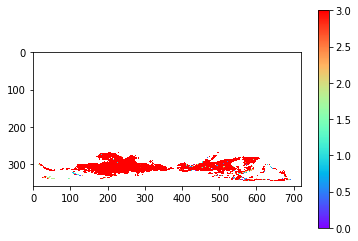

In [58]:
plt.imshow(another_mask,cmap='rainbow',vmin=0, vmax=3)
plt.colorbar()

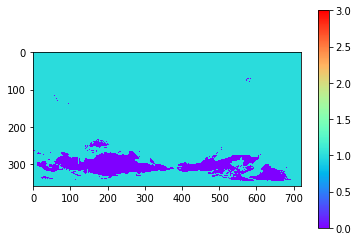

In [59]:
plt.imshow(dv_msk,cmap='rainbow',vmin=0, vmax=3)
plt.colorbar()

In [97]:
# Input C fluxes
# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
val_lab_top = np.ones((nlat, nlon))*float("nan")
val_lab_sub = np.ones((nlat, nlon))*float("nan")
val_res_top = np.ones((nlat, nlon))*float("nan")
val_res_sub = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
        val_lab_top[i,j] = input_lab_top[i,j] * grid_area[i,j]
        val_lab_sub[i,j] = input_lab_sub[i,j] * grid_area[i,j]
        val_res_top[i,j] = input_res_top[i,j] * grid_area[i,j]
        val_res_sub[i,j] = input_res_sub[i,j] * grid_area[i,j]        

input_lab_top_tot = np.nansum(val_lab_top)/1e12
input_lab_sub_tot = np.nansum(val_lab_sub)/1e12
input_res_top_tot = np.nansum(val_res_top)/1e12
input_res_sub_tot = np.nansum(val_res_sub)/1e12

print('Input labile topsoil ...')
print(input_lab_top_tot)
print('Input labile subsoil ...')
print(input_lab_sub_tot)
print('Input resistant topsoil ...')
print(input_res_top_tot)
print('Input resistant subsoil ...')
print(input_res_sub_tot)


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Warning: converting a masked element to nan.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Warning: converting a masked element to nan.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Warning: converting a masked element to nan.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.


Input labile topsoil ...
4.0567109089383795
Input labile subsoil ...
0.2541533491627922
Input resistant topsoil ...
0.4152021631852045
Input resistant subsoil ...
0.029570448279085105


In [98]:
# Respiration C fluxes
# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
val_lab_top = np.ones((nlat, nlon))*float("nan")
val_lab_sub = np.ones((nlat, nlon))*float("nan")
val_res_top = np.ones((nlat, nlon))*float("nan")
val_res_sub = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
        val_lab_top[i,j] = resp_lab_top[i,j] * grid_area[i,j]
        val_lab_sub[i,j] = resp_lab_sub[i,j] * grid_area[i,j]
        val_res_top[i,j] = resp_res_top[i,j] * grid_area[i,j]
        val_res_sub[i,j] = resp_res_sub[i,j] * grid_area[i,j]        

resp_lab_top_tot = np.nansum(val_lab_top)/1e12
resp_lab_sub_tot = np.nansum(val_lab_sub)/1e12
resp_res_top_tot = np.nansum(val_res_top)/1e12
resp_res_sub_tot = np.nansum(val_res_sub)/1e12

print('Respiration labile topsoil ...')
print(resp_lab_top_tot)
print('Respiration labile subsoil ...')
print(resp_lab_sub_tot)
print('Respiration resistant topsoil ...')
print(resp_res_top_tot)
print('Respiration resistant subsoil ...')
print(resp_res_sub_tot)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Warning: converting a masked element to nan.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Warning: converting a masked element to nan.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Warning: converting a masked element to nan.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.


Respiration labile topsoil ...
3.397833109688692
Respiration labile subsoil ...
0.22396119930946085
Respiration resistant topsoil ...
0.25183448714142553
Respiration resistant subsoil ...
0.04061417976297514


In [99]:
# SOC
# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
val_lab_top = np.ones((nlat, nlon))*float("nan")
val_lab_sub = np.ones((nlat, nlon))*float("nan")
val_res_top = np.ones((nlat, nlon))*float("nan")
val_res_sub = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
        val_lab_top[i,j] = soc_lab_top[i,j] * grid_area[i,j]
        val_lab_sub[i,j] = soc_lab_sub[i,j] * grid_area[i,j]
        val_res_top[i,j] = soc_res_top[i,j] * grid_area[i,j]
        val_res_sub[i,j] = soc_res_sub[i,j] * grid_area[i,j]        

soc_lab_top_tot = np.nansum(val_lab_top)/1e12
soc_lab_sub_tot = np.nansum(val_lab_sub)/1e12
soc_res_top_tot = np.nansum(val_res_top)/1e12
soc_res_sub_tot = np.nansum(val_res_sub)/1e12

print('SOC labile topsoil ...')
print(soc_lab_top_tot)
print('SOC labile subsoil ...')
print(soc_lab_sub_tot)
print('SOC resistant topsoil ...')
print(soc_res_top_tot)
print('SOC resistant subsoil ...')
print(soc_res_sub_tot)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Warning: converting a masked element to nan.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Warning: converting a masked element to nan.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Warning: converting a masked element to nan.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.


SOC labile topsoil ...
46.70896027405193
SOC labile subsoil ...
32.18671846556299
SOC resistant topsoil ...
79.50783364169243
SOC resistant subsoil ...
170.8676153510516


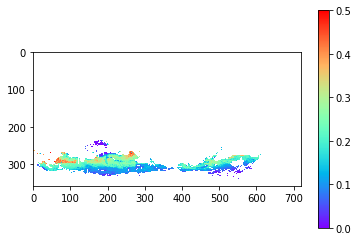

In [18]:
# Plots to check some results
plt.imshow(soc_lab_top_tot,cmap='rainbow',vmin=0, vmax=0.5)
plt.colorbar()

319

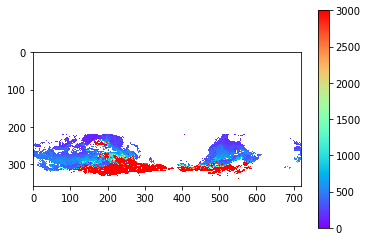

In [14]:
plt.imshow(tau_res_sub,cmap='rainbow',vmin=0, vmax=3000)
plt.colorbar()

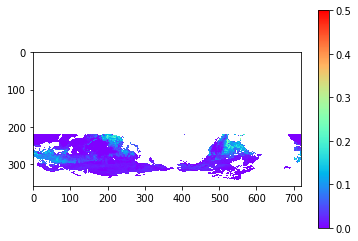

In [11]:
plt.imshow(input_lab_sub,cmap='rainbow',vmin=0, vmax=0.5)
plt.colorbar()

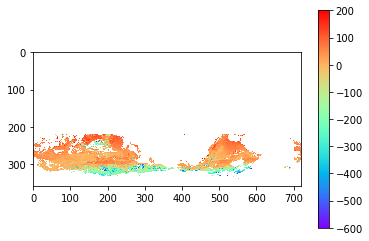

In [36]:
plt.imshow(d14c_res_top,cmap='rainbow',vmin=-600, vmax=200)
plt.colorbar()

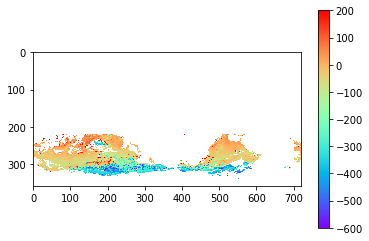

In [37]:
plt.imshow(d14c_res_sub,cmap='rainbow',vmin=-600, vmax=200)
plt.colorbar()

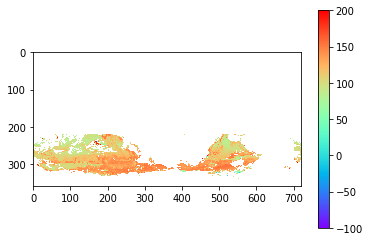

In [38]:
plt.imshow(d14c_lab_top,cmap='rainbow',vmin=-100, vmax=200)
plt.colorbar()

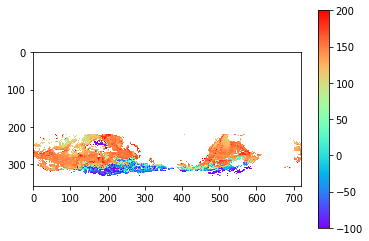

In [39]:
plt.imshow(d14c_lab_sub,cmap='rainbow',vmin=-100, vmax=200)
plt.colorbar()

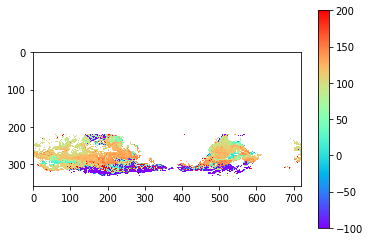

In [30]:
plt.imshow(d14c_lab_tot,cmap='rainbow',vmin=-100, vmax=200)
plt.colorbar()

In [ ]:
# Here read in the results and calculate the D14C for labile vs. resistance pool
# fsample = 'Global_1DSBGC.bgc-yearly-d14c-4d_1860s.nc'
# nclu_obs=NetCDFFile(fsample,'r')
# soc_1860 = nclu_obs.variables['soc_pools'][:]
# soc14_1860 = nclu_obs.variables['soc14_pools'][:]
# nclu_obs.close()

fsample = 'Global_1DSBGC.bgc-yearly-d14c-4d_2000s.nc'
nclu_obs=NetCDFFile(fsample,'r')
soc = nclu_obs.variables['soc_pools'][:]
soc14 = nclu_obs.variables['soc14_pools'][:]
nclu_obs.close()

# Need to get the mask to prevent running for useless grids.
fdv = 'dave_mask.nc'
nclu_obs=NetCDFFile(fdv,'r')
dv_msk = nclu_obs.variables['Davemask'][:]
nclu_obs.close()

# First calculate the D14C
soc[soc<=0] = np.float('nan')
soc14[soc14<=0] = np.float('nan')
d14c_lab = 1000.*(np.nansum(soc14[:,0:7,:,:], axis=1)/np.nansum(soc[:,0:7,:,:], axis=1) - 1)
d14c_res = 1000.*(soc14[:,7,:,:]/soc[:,7,:,:] - 1)


rc14c12 = d14c/1000. + 1


rc14c12_all = -1000*np.ones((10, 360, 720))
for i in np.arange(0,10):
    rc14c12_all[i,:,:] = np.sum((rc14c12[i,:,:,:] * lc), axis=0)

d14c_all = 1000.*(rc14c12_all - 1)
    
d14c_all[d14c_all==0] = np.float('nan')
# Get a mask to filter out grids with no values
msk = d14c_all[0,:,:]
msk[dv_msk>0] = -1000

tau_topsoil = np.zeros((360, 720))
tau_subsoil = np.zeros((360, 720))
bulk_d14c_topsoil = -1000*np.ones((360, 720))
bulk_d14c_subsoil = -1000*np.ones((360, 720))

for i in np.arange(0,720):
    for j in np.arange(0,360):
        if(soc[0,j,i]>0):
            bulk_d14c_topsoil[j,i] = isam.avg_wt_topsoil(soc[:,j,i], d14c_all[:,j,i])
            bulk_d14c_subsoil[j,i] = isam.avg_wt_subsoil(soc[:,j,i], d14c_all[:,j,i])

print('Done the averaging!')

# Calculate the tau, one time for a lat
# Lat starts from 360 to 220 (20N ~ 80N), Dave Mcguire's regional mask is applied
# First transfer into a 1-D array then pass into cal_tau?
for i in np.arange(359,219,-1):
    print(i)
    # Weighted C14 for topsoil and subsoil separatedly
    # Preindustrial year - 1860
    # Contemporary year - 2000
    msk_inuse = msk[i,:]
    sampleyr = 1860*np.ones((720))
    sampleyr[msk_inuse<-400] = np.float('nan')
    # Calculate the turnover time
    tau, cost = C14utils.cal_tau(bulk_d14c_topsoil[i,:], sampleyr, 1, 0)
    tau_topsoil[i,:] = tau[:,0]
    tau, cost = C14utils.cal_tau(bulk_d14c_subsoil[i,:], sampleyr, 1, 0)
    tau_subsoil[i,:] = tau[:,0]

tau_topsoil[tau_topsoil>3000] = np.float('nan')
tau_subsoil[tau_subsoil>10000] = np.float('nan')

# Save the file as netcdf for display
# Create a NetCDF file to store the result
nc = NetCDFFile('tau_1d_1860s.nc','w',format='NETCDF4_CLASSIC')
# Define a set of dimensions to be used in the file
#level = nc.createDimension('level', 10)
lat = nc.createDimension('lat', 360)
lon = nc.createDimension('lon', 720)
# Create variables
#levels = nc.createVariable('level', np.int32, ('level',))
latitudes = nc.createVariable('lat', np.float32, ('lat',))
longitudes = nc.createVariable('lon', np.float32, ('lon',))
# Create the actual 4-d variable
tau_top = nc.createVariable('tau_top', np.float32, ('lat','lon'))
tau_sub = nc.createVariable('tau_sub', np.float32, ('lat','lon'))

# Add Global Attributes
nc.description = 'Tau calculated from the Soil D14C.'
nc.history = 'Created ' + time.ctime(time.time())
nc.source = 'netCDF4 python module'

# Add Variable Attributes
latitudes.units = 'degree_north'
longitudes.units = 'degree_east'
tau_top.units = 'year'
tau_sub.units = 'year'

# Put longitude and latitude
lats = np.arange(-89.75,90.25,0.5)
lons = np.arange(0.25,360.25,0.5)
latitudes[:] = lats
longitudes[:] = lons
tau_top[:,:] = tau_topsoil
tau_sub[:,:] = tau_subsoil
nc.close()

In [ ]:
np.shape(tau_topsoil)

In [ ]:
os.system("echo $DISPLAY")

In [ ]:
bgc14[8,:,3,317,220]

In [ ]:
bgc14_new[8,:,3,317,220]

In [ ]:
agc14_new[1,8,1,318,290]

In [ ]:
# A small test
a=bgc_new[1,8,0,318,290]*bgc14[1,8,0,318,290]/bgc[1,8,0,318,290]
b=bgc_new[1,8,1,318,290]*bgc14[1,8,1,318,290]/bgc[1,8,1,318,290]
c=bgc_new[1,8,2,318,290]*bgc14[1,8,2,318,290]/bgc[1,8,2,318,290]
d=bgc_new[1,8,3,318,290]*bgc14[1,8,3,318,290]/bgc[1,8,3,318,290]

In [ ]:
(a+b+c+d)/(bgc_new[1,8,0,318,290]+bgc_new[1,8,1,318,290]+bgc_new[1,8,2,318,290]+bgc_new[1,8,3,318,290])

In [ ]:
(bgc14[1,8,0,318,290]+bgc14[1,8,1,318,290]+bgc14[1,8,2,318,290]+bgc14[1,8,3,318,290])/(bgc[1,8,0,318,290]+bgc[1,8,1,318,290]+bgc[1,8,2,318,290]+bgc[1,8,3,318,290])

In [ ]:
1000*(0.9612-1)

In [ ]:
## OLD METHOD seems not working... I now changed to use the calculated D14C for calculating back the soc14 based on soc of the new initial file
# 2. Obtain the C and 14C content 
# Open SBGC restart

#path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscd_masked_0.5x0.5.nc'
nclu_obs=NetCDFFile(fc14,'r')
agcbox = nclu_obs.variables['agcbox'][:]
bgcbox = nclu_obs.variables['bgcbox'][:]
agcprof = nclu_obs.variables['agcprof'][:]
bgcprof = nclu_obs.variables['bgcprof'][:]
agc14box = nclu_obs.variables['agc14box'][:]
bgc14box = nclu_obs.variables['bgc14box'][:]
agc14prof = nclu_obs.variables['agc14prof'][:]
bgc14prof = nclu_obs.variables['bgc14prof'][:]
latnc = nclu_obs.variables['lat'][:]
lonnc = nclu_obs.variables['lon'][:]
nclu_obs.close()

nclu_obs=NetCDFFile(fbgc,'r')
agcbox_new = nclu_obs.variables['agcbox'][:]
bgcbox_new = nclu_obs.variables['bgcbox'][:]
agcprof_new = nclu_obs.variables['agcprof'][:]
bgcprof_new = nclu_obs.variables['bgcprof'][:]
agc14box_new = nclu_obs.variables['agc14box'][:]
bgc14box_new = nclu_obs.variables['bgc14box'][:]
agc14prof_new = nclu_obs.variables['agc14prof'][:]
bgc14prof_new = nclu_obs.variables['bgc14prof'][:]
nclu_obs.close()

soc14_agc = np.zeros((10,24,4,360,720))
soc14_bgc = np.zeros((10,24,5,360,720))
soc_agc = np.zeros((10,24,4,360,720))
soc_bgc = np.zeros((10,24,5,360,720))
soc14_agc_new = np.zeros((10,24,4,360,720))
soc14_bgc_new = np.zeros((10,24,5,360,720))
soc_agc_new = np.zeros((10,24,4,360,720))
soc_bgc_new = np.zeros((10,24,5,360,720))

# 3. Calculate back soc and soc14 profiles
for lev in np.arange(0,10):
    soc14_agc[lev,:,:,:,:] = agc14box * agc14prof[lev,:,:,:,:]/10000.
    soc14_bgc[lev,:,:,:,:] = bgc14box * bgc14prof[lev,:,:,:,:]/10000.
    soc_agc[lev,:,:,:,:] = agcbox * agcprof[lev,:,:,:,:]/10000.
    soc_bgc[lev,:,:,:,:] = bgcbox * bgcprof[lev,:,:,:,:]/10000.

c14c12_agc = soc14_agc/soc_agc
c14c12_bgc = soc14_bgc/soc_bgc

# Change the soc14 profiles based on the c14/c12 and soc profiles
for lev in np.arange(0,10):
    soc_agc_new[lev,:,:,:,:] = agcbox_new * agcprof[lev,:,:,:,:]/10000.
    soc_bgc_new[lev,:,:,:,:] = bgcbox_new * bgcprof[lev,:,:,:,:]/10000.

soc14_agc_new = c14c12_agc * soc_agc_new
soc14_bgc_new = c14c12_bgc * soc_bgc_new

# 4. Update the SOC14 pool size after getting the new profile
soc14_agc_tot = np.nansum(soc14_agc_new, axis=0)
soc14_bgc_tot = np.nansum(soc14_bgc_new, axis=0)

# Calculate the new profile factor
soc14_agcprof_new = np.zeros((10,24,4,360,720))
soc14_bgcprof_new = np.zeros((10,24,5,360,720))
for lev in np.arange(0,10):
    soc14_agcprof_new[lev,:,:,:,:] = soc14_agc_new[lev,:,:,:,:]/soc14_agc_tot * 10000.
    soc14_bgcprof_new[lev,:,:,:,:] = soc14_bgc_new[lev,:,:,:,:]/soc14_bgc_tot * 10000.
soc14_agcprof_new[soc14_agcprof_new<0]=0
soc14_bgcprof_new[soc14_bgcprof_new<0]=0
#soc14_agcprof_new.astype('int')
#soc14_bgcprof_new.astype('int')

# 5. Store back the SOC14 into the restart file
fout = 'bgc.isam_initial.1dbgc_new.nc'
nclu_obs=NetCDFFile(fout,'a')
nclu_obs.variables['agc14prof'][:] = soc14_agcprof_new.astype('int')
nclu_obs.variables['bgc14prof'][:] = soc14_bgcprof_new.astype('int')
nclu_obs.variables['agc14box'][:] = soc14_agc_tot
nclu_obs.variables['bgc14box'][:] = soc14_bgc_tot
nclu_obs.close()


In [ ]:
# Make Plot
# Can continue later
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(30,24))

ax1 = fig.add_subplot(231)
ax1.set_title("ISAM-1D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
xs, ys = np.meshgrid(lonnc3, latnc3)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,soc_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
# Overlap scatter plot to show the peatland distribution
#map.scatter(xs, ys, s = 4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 4*histel, latlon=True, marker='_', color='cyan')
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
plt.annotate('(a)', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#parallels = np.arange(45.,80.,15.)
## labels = [left,right,top,bottom]
#map.drawparallels(parallels)#,labels=[False,True,True,False])
#meridians = np.arange(15.,346.,30.)
#map.drawmeridians(meridians)#,labels=[True,False,False,True])

map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=30) 

ax2 = fig.add_subplot(232)
ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,soc0d_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=32, labelpad=10)
plt.annotate('(b)', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=30) 

lon2,lat2 = np.meshgrid(lonnc2,latnc2) #Returns coordinate matrices from coordinate vectors
x2,y2 = map(lon2,lat2)
ax2 = fig.add_subplot(233)
ax2.set_title("NCSCD SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x2,y2,soc_ncscd_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                     # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
plt.annotate('(c)', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=30) 

ax3 = fig.add_subplot(234)
ax3.set_title("ISAM-1D SOC turnover time",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,tau_contemp_perm[:,:],
              norm=colors.LogNorm(vmin=1,vmax=1500.),cmap=plt.cm.summer) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,ticks=[1, 10, 100, 1000, 5000],location='bottom',pad="5%",extend='both', format=ticker.LogFormatter())
plt.annotate('(a)', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.set_xticklabels([0, 200, 400, 600, 800])  # horizontal colorbar
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=30) 

ax3 = fig.add_subplot(235)
ax3.set_title("ISAM-0D SOC turnover time",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,tau0d_contemp_perm[:,:],
              norm=colors.LogNorm(vmin=1,vmax=1500.),cmap=plt.cm.summer) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,ticks=[1, 10, 100, 1000, 5000],location='bottom',pad="5%",extend='both', format=ticker.LogFormatter())
cbar.ax.set_xlabel('Unit: year', fontsize=32, labelpad=10)
plt.annotate('(b)', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.set_xticklabels([0, 200, 400, 600, 800])  # horizontal colorbar
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=30) 

#plt.show()
plt.savefig('./figures/fig6.png',dpi=300)

In [ ]:
plt.imshow(soc_contemp_perm)

In [ ]:
soc_contemp_perm = copy.deepcopy(soc_contemp)

In [ ]:
plt.imshow(dsoc)

In [ ]:
# Mask all regions outside the northern permafrost extent
dsoc_perm = copy.deepcopy(dsoc)
dsoc_perm.mask = another_mask.mask
dsoc0d_perm = copy.deepcopy(dsoc0d)
dsoc0d_perm.mask = another_mask.mask
dtau_perm = copy.deepcopy(dtau)
dtau_perm.mask = another_mask.mask
dtau0d_perm = copy.deepcopy(dtau0d)
dtau0d_perm.mask = another_mask.mask

# Plot the figure7
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(18,15))

#ax1 = fig.add_subplot(331)
ax1 = fig.add_subplot(221)
ax1.set_title("ISAM-1D SOC stock (2009 - 1960)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,dsoc_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.coolwarm) # use log color scale,
cbar = map.colorbar(cs1,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM-0D SOC stock (2009 - 1960)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs2 = map.pcolormesh(x,y,dsoc0d_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.coolwarm) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs2,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=0)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 


ax3 = fig.add_subplot(223)
ax3.set_title("ISAM-1D SOC turnover time (2009 - 1960)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs3 = map.pcolormesh(x,y,dtau_perm[:,:],
#              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.coolwarm) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs3,ticks=[-100, -10, -1, 0, 1, 10, 100],location='bottom',pad="5%",extend='both', format=ticker.LogFormatter())
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(c)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM-0D SOC turnover time (2009 - 1960)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dtau0d_perm[:,:],
#              norm=colors.Normalize(vmin=-60.,vmax=60.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.coolwarm) # use log color scale,

cbar = map.colorbar(cs4,ticks=[-100, -10, -1, 0, 1, 10, 100],location='bottom',pad="5%",extend='both', format=ticker.LogFormatter())
cbar.ax.set_xlabel('Unit: $year$', fontsize=20, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(d)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

#plt.show()
plt.savefig('./figures/fig7.png',dpi=300)

In [ ]:
dsoc_top_perm = soc_top_contemp_perm - soc_top_preind_perm
dsoc_sub_perm = soc_sub_contemp_perm - soc_sub_preind_perm

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM 1D topsoil SOC change (kgC/m2)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,dsoc_top_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.coolwarm) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM 1D subsoil SOC change (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dsoc_sub_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.coolwarm) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=10)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

# Set one colorbar for both subplots
# make an axes to put the shared colorbar in
#fig.subplots_adjust(bottom=0.1)
#colorbar_axes = plt.gcf().add_axes([0.35, 0.1, 0.3, 0.05])
#colorbar = plt.colorbar(cs, colorbar_axes, orientation='horizontal')
#colorbar_axes.tick_params(labelsize=20) 
#colorbar.set_label('Unit: $KgC m^{-2}$', fontsize=24)

#plt.show()
plt.savefig('./figures/fig8.png',dpi=300)

In [ ]:
# Plot the figure3
# Mask all regions outside the northern permafrost extent
resp_contemp_perm = copy.deepcopy(resp_contemp)
resp_contemp_perm.mask = another_mask.mask
resp0d_contemp_perm = copy.deepcopy(resp0d_contemp)
resp0d_contemp_perm.mask = another_mask.mask
resp_preind_perm = copy.deepcopy(resp_preind)
resp_preind_perm.mask = another_mask.mask
resp0d_preind_perm = copy.deepcopy(resp0d_preind)
resp0d_preind_perm.mask = another_mask.mask
dresp_perm = copy.deepcopy(dresp)
dresp_perm.mask = another_mask.mask
dresp0d_perm = copy.deepcopy(dresp0d)
dresp0d_perm.mask = another_mask.mask

# Comparison of Soil respiration and the change
fig = plt.figure(figsize=(18,15))

ax1 = fig.add_subplot(221)
ax1.set_title("ISAM 0D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,1000.*resp0d_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM 0D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp0d_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax3 = fig.add_subplot(223)
ax3.set_title("ISAM 1D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*resp_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM 1D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

plt.show()
#plt.savefig('Fig9.jpg',dpi=300)